In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


100%|██████████| 26.4M/26.4M [00:02<00:00, 9.05MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 151kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.81MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.3MB/s]


In [3]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 400),
            nn.ReLU()
        )

        self.mu = nn.Linear(400, 20)
        self.logvar = nn.Linear(400, 20)

        self.decoder = nn.Sequential(
            nn.Linear(20, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar


In [4]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        recon_x, x.view(-1, 28*28), reduction='sum'
    )
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 10

for epoch in range(epochs):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)

        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)
        loss = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader.dataset):.4f}")


Epoch 1, Loss: 286.6144
Epoch 2, Loss: 257.4350
Epoch 3, Loss: 251.3482
Epoch 4, Loss: 248.2008
Epoch 5, Loss: 246.4386
Epoch 6, Loss: 245.3049
Epoch 7, Loss: 244.4517
Epoch 8, Loss: 243.7897
Epoch 9, Loss: 243.3110
Epoch 10, Loss: 242.8631


In [13]:
# Generate samples
model.eval()
with torch.no_grad():
    # Random sampling
    z = torch.randn(16, 20).to(device)
    samples = model.decoder(z).cpu().view(-1, 1, 28, 28)

    # Reconstruct from last batch
    x_sample, _, _ = model(x[:16])  # Take first 16 images from last batch
    x_sample = x_sample.view(-1, 1, 28, 28).cpu()

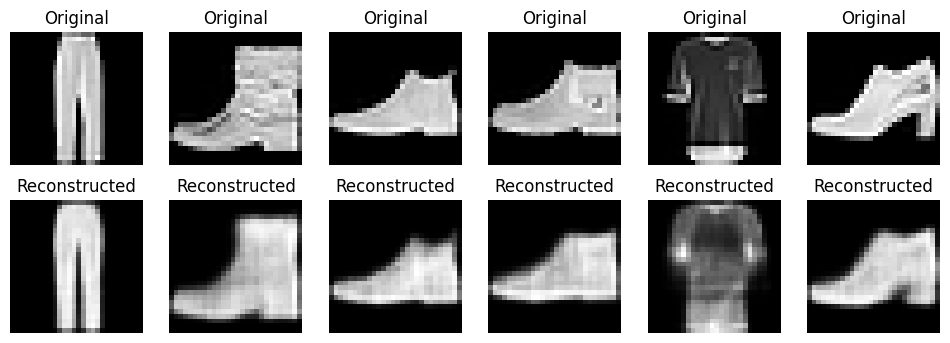

In [15]:
# Plotting
n = 6
plt.figure(figsize=(12, 4))

for i in range(n):
    # Original
    plt.subplot(2, n, i+1)
    plt.imshow(x[i].cpu().squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed
    plt.subplot(2, n, i+1+n)
    plt.imshow(x_sample[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()